# Actividad 4 | Métricas de calidad de resultados
---

**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4034.10 - Análisis de grandes volúmenes de datos**

Tecnológico de Monterrey

* Dr. Iván Olmos Pineda
* Mtra. Verónica Sandra Guzmán de Valle
* Mtro. Alberto Daniel Salinas Montemayor

---

**Datos del alumno**

|  NOMBRE COMPLETO                        |     MATRÍCULA     |
| :-------------------------------------: |:-----------------:|
| Emiliano Saucedo Arriola                |  A01659258        |

# Actividad 4

## 0. Inicialización

In [24]:
import findspark

from pyspark.sql import SparkSession, functions as F
from pyspark.sql import functions as F
from pyspark.sql.types import *
from functools import reduce
from operator import and_

import os
from concurrent.futures import ThreadPoolExecutor

import pandas as pd

from pyspark.sql import DataFrame
from pyspark.sql.functions import col, log1p
from pyspark.ml.feature import StringIndexer

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [25]:
findspark.init()
findspark.find()

'/Users/emisaar/anaconda3/envs/pyspark_env/lib/python3.10/site-packages/pyspark'

In [26]:
class FileManager():
    @staticmethod
    def open_csv_file(file_path: str):
        """
        Abre un archivo CSV usando PySpark con configuraciones optimizadas
        """
        csv_df = spark.read.csv(
            file_path,
            header=True,
            inferSchema=True,
            multiLine=True,
            escape="\"",
            quote="\""
        )
        
        print(f"Dataset original cargado: {csv_df.count():,} registros")
        csv_df.show(5, truncate=20)
        return csv_df

In [27]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [28]:
import kagglehub

FILE_PATH = kagglehub.dataset_download("machharavikiran/amazon-reviews")
print("Path to dataset files:", FILE_PATH)

/Users/emisaar/anaconda3/envs/pyspark_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/emisaar/.cache/kagglehub/datasets/machharavikiran/amazon-reviews/versions/1


In [29]:
# Cargar dataset (población P)
df_reviews_P = FileManager.open_csv_file(FILE_PATH)

Dataset original cargado: 6,906,564 registros
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|sentiment|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------+
|         US|   22873041|R3ARRMDEGED8RD|B00KJWQIIC|     335625766|Plemo 14-Inch Lap...|              PC|          5|            0|          0|   N|                Y|Pleasantly surprised|I was very surpri...| 2015-08-31|        1|
|         US|   30088427| RQ28TSA0

## 1.  Construcción de la muestra M

In [30]:
# Definir variables de caracterización
characterization_variables = ["star_rating", "verified_purchase", "vine"]

#### Análisis de la población P

En este apartado se realiza un análisis exploratorio sobre el dataset completo (población P). El objetivo es comprender la distribución general de las variables de caracterización (`star_rating`, `verified_purchase`, `vine`) y cómo se combinan entre sí, para identificar patrones, sesgos y grupos minoritarios.

In [31]:
# Analizar distribución de la población
total_count = df_reviews_P.count()
print(f"Tamaño total de la población P: {total_count:,} registros")

Tamaño total de la población P: 6,906,564 registros


In [32]:
# Calcular distribución de cada variable individual
for var in characterization_variables:
    print(f"\nDistribución de {var}:")
    var_dist = df_reviews_P.groupBy(var).count() \
                .withColumn("percentage", F.round(F.col("count") * 100.0 / total_count, 2)) \
                .orderBy("count", ascending=False)
    var_dist.show()


Distribución de star_rating:


+-----------+-------+----------+
|star_rating|  count|percentage|
+-----------+-------+----------+
|          5|4105687|     59.45|
|          4|1168208|     16.91|
|          1| 756857|     10.96|
|          3| 513656|      7.44|
|          2| 362156|      5.24|
+-----------+-------+----------+


Distribución de verified_purchase:


+-----------------+-------+----------+
|verified_purchase|  count|percentage|
+-----------------+-------+----------+
|                Y|6047075|     87.56|
|                N| 859489|     12.44|
+-----------------+-------+----------+


Distribución de vine:


+----+-------+----------+
|vine|  count|percentage|
+----+-------+----------+
|   N|6870336|     99.48|
|   Y|  36228|      0.52|
+----+-------+----------+



**Observaciones**

***Distribución de calificaciones (`star_rating`)***
* El 59.45% de las reseñas son de 5 estrellas, mostrando un fuerte sesgo positivo.
* Las reseñas con 1 estrella representan el 10.96%, mientras que las reseñas intermedias (2–4 estrellas) representan el resto.

***Distribución de compras verificadas (`verified_purchase`)***
* La gran mayoría (87.56%) proviene de usuarios con compra verificada, indicando que la base de datos tiene un fuerte enfoque en opiniones genuinas.

***Distribución del programa Vine (`vine`)***
* Solo el 52% de las reseñas provienen del programa Vine (usuarios seleccionados para reseñar productos), mientras que el 99.48% no pertenece a este grupo, haciéndolo un segmento muy minoritario.

In [33]:
# Calcular distribución conjunta
print(f"Distribución conjunta de {characterization_variables}:")
population_dist = df_reviews_P.groupBy(characterization_variables).count() \
                .withColumn("probability", F.round(F.col("count") / total_count, 6)) \
                .orderBy("probability", ascending=False)
population_dist.show(20)

Distribución conjunta de ['star_rating', 'verified_purchase', 'vine']:


+-----------+-----------------+----+-------+-----------+
|star_rating|verified_purchase|vine|  count|probability|
+-----------+-----------------+----+-------+-----------+
|          5|                Y|   N|3679909|   0.532813|
|          4|                Y|   N|1019728|   0.147646|
|          1|                Y|   N| 603371|   0.087362|
|          3|                Y|   N| 443364|   0.064195|
|          5|                N|   N| 410073|   0.059374|
|          2|                Y|   N| 300544|   0.043516|
|          1|                N|   N| 152779|   0.022121|
|          4|                N|   N| 135197|   0.019575|
|          3|                N|   N|  65398|   0.009469|
|          2|                N|   N|  59973|   0.008683|
|          5|                N|   Y|  15604|   0.002259|
|          4|                N|   Y|  13240|   0.001917|
|          3|                N|   Y|   4886|    7.07E-4|
|          2|                N|   Y|   1634|    2.37E-4|
|          1|                N|

**Observaciones**
* Más de la mitad son reseñas de 5 estrellas, verificadas y sin Vine (53.28%).
* Los grupos minoritarios, como reseñas de Vine con calificaciones bajas (1-3), tienen probabilidades extremadamente pequeñas.
* Esto confirma que la población está altamente desbalanceada, con algunos grupos muy dominantes y otros extremadamente escasos.

#### Filtrado de los estratos

In [34]:
# Identificar estratos relevantes (combinaciones con suficiente probabilidad)
min_probability = 0.0001
relevant_strata = population_dist.filter(F.col("probability") >= min_probability).collect()

print(f"Estratos identificados: {len(relevant_strata)}")
print(f"Probabilidad mínima requerida: {min_probability:.6f}")

Estratos identificados: 15
Probabilidad mínima requerida: 0.000100


**Observaciones**

Al analizar todas las combinaciones posibles de las variables de caracterización, se seleccionaron solo aquellos estratos (15 identificados) que tienen una probabilidad mínima (mayor o igual a 0.0001) de ocurrencia en la población. Esto asegura trabajar solo con grupos significativos.

#### Fracción de muestreo
A continuación, se construye un diccionario en el que se calcula la fracción de muestreo que se aplicará a cada estrato relevante para construir la muestra representativa M. Para mantener la diversidad y la representatividad de los datos, se optó por tomar el 10% de cada grupo, con un pequeño ajuste (~12%) para compensar la variabilidad aleatoria del muestreo y evitar que algunos grupos minoritarios terminen demasiado reducidos.

In [35]:
# Crear fracciones de muestreo para cada estrato
strata_fractions = {}
sample_fraction = 0.1
total_population = df_reviews_P.count()

for row in relevant_strata:
    # Crear clave única para el estrato
    star_label = f"R{row['star_rating']}"
    vp_label = f"VP{'Y' if row['verified_purchase'] == 'Y' else 'N'}"
    vine_label = f"V{'Y' if row['vine'] == 'Y' else 'N'}"

    strata_key = f"{star_label}_{vp_label}_{vine_label}"
    
    # Calcular fracción de muestreo para mantener representatividad
    strata_fraction = min(sample_fraction * 1.2, 0.5)  # Ligeramente mayor para compensar variabilidad
    strata_fractions[strata_key] = strata_fraction
    
    print(f"Estrato {strata_key}: {row['count']:,} registros, fracción: {strata_fraction:.3f}")

Estrato R5_VPY_VN: 3,679,909 registros, fracción: 0.120
Estrato R4_VPY_VN: 1,019,728 registros, fracción: 0.120
Estrato R1_VPY_VN: 603,371 registros, fracción: 0.120
Estrato R3_VPY_VN: 443,364 registros, fracción: 0.120
Estrato R5_VPN_VN: 410,073 registros, fracción: 0.120
Estrato R2_VPY_VN: 300,544 registros, fracción: 0.120
Estrato R1_VPN_VN: 152,779 registros, fracción: 0.120
Estrato R4_VPN_VN: 135,197 registros, fracción: 0.120
Estrato R3_VPN_VN: 65,398 registros, fracción: 0.120
Estrato R2_VPN_VN: 59,973 registros, fracción: 0.120
Estrato R5_VPN_VY: 15,604 registros, fracción: 0.120
Estrato R4_VPN_VY: 13,240 registros, fracción: 0.120
Estrato R3_VPN_VY: 4,886 registros, fracción: 0.120
Estrato R2_VPN_VY: 1,634 registros, fracción: 0.120
Estrato R1_VPN_VY: 705 registros, fracción: 0.120


#### Construcción de M

Para cada estrato, se filtran los registros y se toma una muestra utilizando la fracción previamente calculada. Este muestreo se realiza con una semilla fija (seed=42) para garantizar la reproducibilidad. Además, se asegura que no haya reemplazo (`withReplacement=False`), lo que significa que cada registro puede aparecer solo una vez en la muestra final.

Fuentes consultadas:
* https://www.geeksforgeeks.org/pyspark-random-sample-with-example/

In [36]:
# Aplicar muestreo estratificado
sample_parts = []

for row in relevant_strata:
    # Filtrar datos del estrato actual
    conditions = [F.col(var) == row[var] for var in characterization_variables]
    combined_condition = conditions[0]
    for condition in conditions[1:]:
        combined_condition = combined_condition & condition
    
    strata_data = df_reviews_P.filter(combined_condition)
    
    # Crear clave única para el estrato
    star_label = f"R{row['star_rating']}"
    vp_label = f"VP{'Y' if row['verified_purchase'] == 'Y' else 'N'}"
    vine_label = f"V{'Y' if row['vine'] == 'Y' else 'N'}"

    strata_key = f"{star_label}_{vp_label}_{vine_label}"
    fraction = strata_fractions[strata_key]
    
    # Aplicar muestreo con semilla fija para reproducibilidad
    sampled_strata = strata_data.sample(withReplacement=False, fraction=fraction, seed=42)
    sample_parts.append(sampled_strata)
    
    print(f"Muestreados {sampled_strata.count():,} de {strata_data.count():,} en estrato {strata_key}")

Muestreados 442,073 de 3,679,909 en estrato R5_VPY_VN


Muestreados 122,773 de 1,019,728 en estrato R4_VPY_VN


Muestreados 72,444 de 603,371 en estrato R1_VPY_VN


Muestreados 53,285 de 443,364 en estrato R3_VPY_VN


Muestreados 49,191 de 410,073 en estrato R5_VPN_VN


Muestreados 36,089 de 300,544 en estrato R2_VPY_VN


Muestreados 18,316 de 152,779 en estrato R1_VPN_VN


Muestreados 16,171 de 135,197 en estrato R4_VPN_VN


Muestreados 7,838 de 65,398 en estrato R3_VPN_VN


Muestreados 7,208 de 59,973 en estrato R2_VPN_VN


Muestreados 1,936 de 15,604 en estrato R5_VPN_VY


Muestreados 1,674 de 13,240 en estrato R4_VPN_VY


Muestreados 606 de 4,886 en estrato R3_VPN_VY


Muestreados 213 de 1,634 en estrato R2_VPN_VY


Muestreados 83 de 705 en estrato R1_VPN_VY


Posteriormente, se unen todas las submuestras recolectadas de los distintos estratos para construir la muestra representativa M. Esto se logra concatenando cada subconjunto, asegurando que todos los grupos seleccionados formen parte del conjunto final.

In [37]:
# Unir todas las partes para formar la muestra M
sample_M = sample_parts[0]
for part in sample_parts[1:]:
    sample_M = sample_M.union(part)

In [38]:
# Validar que la muestra M sea representativa de la población P
# Comparar distribuciones
pop_total = df_reviews_P.count()
sample_total = sample_M.count()

print(f"Población P: {pop_total:,} registros")
print(f"Muestra M: {sample_total:,} registros")
print(f"Factor de muestreo: {sample_total/pop_total:.1%}")

Población P: 6,906,564 registros
Muestra M: 829,900 registros
Factor de muestreo: 12.0%


**Observaciones**

Se obtuvo una muestra M de 829,900 registros, equivalente al 12% de la población original.

Aunque el objetivo inicial era obtener aproximadamente el 10%, el ajuste aplicado permitió compensar la variabilidad del proceso de muestreo y asegurar que los estratos más pequeños quedaran representados adecuadamente.

In [39]:
# Comparar distribución de cada variable
for var in characterization_variables:
    print(f"\n--- Comparación para {var} ---")
    
    # Distribución en población
    pop_dist = df_reviews_P.groupBy(var).count() \
                            .withColumn("pop_percentage", F.round(F.col("count") * 100.0 / pop_total, 2)) \
                            .select(var, F.col("pop_percentage"))
    
    # Distribución en muestra
    sample_dist = sample_M.groupBy(var).count() \
                            .withColumn("sample_percentage", F.round(F.col("count") * 100.0 / sample_total, 2)) \
                            .select(var, F.col("sample_percentage"))
    
    # Combinar para comparar
    comparison = pop_dist.join(sample_dist, on=var, how="outer") \
                        .fillna(0) \
                        .withColumn("difference", 
                                    F.abs(F.col("pop_percentage") - F.col("sample_percentage"))) \
                        .orderBy(var)
    
    comparison.show()
    
    # Calcular diferencia promedio
    avg_diff = comparison.agg(F.avg("difference")).collect()[0][0]
    print(f"Diferencia promedio en {var}: {avg_diff:.2f} puntos porcentuales")


--- Comparación para star_rating ---


+-----------+--------------+-----------------+--------------------+
|star_rating|pop_percentage|sample_percentage|          difference|
+-----------+--------------+-----------------+--------------------+
|          1|         10.96|            10.95|0.010000000000001563|
|          2|          5.24|             5.24|                 0.0|
|          3|          7.44|             7.44|                 0.0|
|          4|         16.91|            16.94|0.030000000000001137|
|          5|         59.45|            59.43|0.020000000000003126|
+-----------+--------------+-----------------+--------------------+



Diferencia promedio en star_rating: 0.01 puntos porcentuales

--- Comparación para verified_purchase ---


+-----------------+--------------+-----------------+----------+
|verified_purchase|pop_percentage|sample_percentage|difference|
+-----------------+--------------+-----------------+----------+
|                N|         12.44|            12.44|       0.0|
|                Y|         87.56|            87.56|       0.0|
+-----------------+--------------+-----------------+----------+



Diferencia promedio en verified_purchase: 0.00 puntos porcentuales

--- Comparación para vine ---


+----+--------------+-----------------+--------------------+
|vine|pop_percentage|sample_percentage|          difference|
+----+--------------+-----------------+--------------------+
|   N|         99.48|            99.46|0.020000000000010232|
|   Y|          0.52|             0.54|0.020000000000000018|
+----+--------------+-----------------+--------------------+



Diferencia promedio en vine: 0.02 puntos porcentuales


**Observaciones**

Con esta validación, nos aseguramos que el muestreo estratificado preservó las proporciones de la población, asegurando que la muestra sea representativa y fiable. Los resultados muestran que las diferencias promedio entre la población original y la muestra son casi nulas.

#### (SKIP) Particionamiento 

A continuación, se crean las particiones Mi a partir de la muestra M, filtrando los datos para cada combinación de las variables de caracterización (star_rating, verified_purchase, vine). Para cada combinación, se construye dinámicamente una condición de filtrado que selecciona únicamente los registros que coinciden simultáneamente con esos valores específicos. Solo se conservan las particiones que tienen al menos 100 registros para asegurar que sean suficientemente representativas y útiles para construir más adelante los conjuntos de entrenamiento y prueba. Cada partición se guarda con un nombre descriptivo (como R5_VPY_VN), lo que permite identificar rápidamente a qué grupo pertenece. Al final, se obtiene un conjunto organizado de subconjuntos válidos.

In [ ]:
# # Identificar todas las combinaciones existentes en M
# combinations = sample_M.select(characterization_variables).distinct().collect()

# print(f"Combinaciones encontradas en M: {len(combinations)}")

Combinaciones encontradas en M: 15


In [ ]:
# # Crear particiones Mi
# partitions_Mi = {}
# total_partitioned = 0
# min_partition_size = 100

# for row in combinations:
#     # Crear condiciones de filtrado
#     combined_condition = reduce(and_, [F.col(var) == row[var] for var in characterization_variables])
    
#     # Filtrar para crear la partición
#     partition = sample_M.filter(combined_condition)
#     partition_size = partition.count()
    
#     # Solo incluir si cumple con el tamaño mínimo
#     if partition_size >= min_partition_size:
#         # Crear nombre descriptivo para la partición
#         star_label = f"R{row['star_rating']}"
#         vp_label = f"VP{'Y' if row['verified_purchase'] == 'Y' else 'N'}"
#         vine_label = f"V{'Y' if row['vine'] == 'Y' else 'N'}"

#         partition_key = f"{star_label}_{vp_label}_{vine_label}"
#         partitions_Mi[partition_key] = partition
#         total_partitioned += partition_size
        
#         print(f"Partición {partition_key}: {partition_size:,} registros")
#     else:
#         key_values = [f"{var}={row[var]}" for var in characterization_variables]
#         combination_str = ", ".join(key_values)
#         print(f"Excluida combinación ({combination_str}): solo {partition_size} registros (< {min_partition_size})")

Partición R5_VPY_VN: 442,073 registros


Partición R4_VPY_VN: 122,773 registros


Partición R1_VPY_VN: 72,444 registros


Partición R3_VPY_VN: 53,285 registros


Partición R5_VPN_VN: 49,191 registros


Partición R2_VPY_VN: 36,089 registros


Partición R1_VPN_VN: 18,316 registros


Partición R4_VPN_VN: 16,171 registros


Partición R3_VPN_VN: 7,838 registros


Partición R2_VPN_VN: 7,208 registros


Partición R5_VPN_VY: 1,936 registros


Partición R4_VPN_VY: 1,674 registros


Partición R3_VPN_VY: 606 registros


Partición R2_VPN_VY: 213 registros


Excluida combinación (star_rating=1, verified_purchase=N, vine=Y): solo 83 registros (< 100)


In [ ]:
# # 3. Verificar que la unión de particiones = M
# sample_M_size = sample_M.count()
# coverage = total_partitioned / sample_M_size

# print(f"\n=== RESUMEN DE PARTICIONAMIENTO ===")
# print(f"Particiones Mi creadas: {len(partitions_Mi)}")
# print(f"Registros en M: {sample_M_size:,}")
# print(f"Registros particionados: {total_partitioned:,}")
# print(f'Cobertura: {coverage * 100:.4f}%')


=== RESUMEN DE PARTICIONAMIENTO ===
Particiones Mi creadas: 14
Registros en M: 829,900
Registros particionados: 829,817
Cobertura: 99.9900%


**Observaciones**

Al ejecutar el particionamiento, se crearon 14 particiones Mi, que en conjunto cubren los registros de la muestra M (829,900 registros), donde 829,817 fueron particionados.


## (NEW) 1. Proceso de validación cruzada

En esta etapa se define cómo se evaluará el rendimiento del modelo usando un método llamado validación cruzada, que permite comprobar si el modelo funciona bien en diferentes partes de los datos. Este proceso se aplicará sobre la muestra estratificada M, que contiene 829,900 registros y representa el 12% de la población original de casi 7 millones de registros. La muestra M conserva la diversidad de los 15 grupos más importantes detectados en la población.

Se ha decidido usar validación cruzada con 5 partes (k=5). Esto significa que se dividirá el conjunto de entrenamiento en 5 grupos, y se harán 5 pruebas diferentes donde en cada una se entrena con 4 grupos y se prueba con el restante.

Esta decisión se basa en varios motivos:

- **Representatividad**: Cada uno de los 5 grupos tendrá más de 165 mil registros, y todos conservarán la misma proporción de combinaciones que tiene la muestra original. Esto asegura que los resultados obtenidos en cada prueba sean confiables y reflejen bien la realidad de los datos.

- **Equilibrio entre precisión y esfuerzo**: Usar 5 grupos permite obtener resultados precisos sin hacer que el proceso sea muy lento o pesado para el sistema. Se logra un buen equilibrio entre medir correctamente el rendimiento del modelo y no gastar recursos de más.

- **Mantener la estructura de los datos**: La muestra M fue creada cuidando que todos los tipos de casos importantes estén bien representados. Al dividirla en 5 partes con cuidado, se mantiene esa misma distribución en cada grupo. Esto asegura que ningún grupo tenga demasiados o muy pocos datos de cierto tipo.

- **Control del error y variabilidad**: Al hacer 5 pruebas independientes, podemos saber si el modelo es estable o si cambia mucho su rendimiento dependiendo de los datos que usa. Esto da más seguridad a la hora de tomar decisiones sobre qué modelo funciona mejor.

- **Eficiencia en el uso de recursos**: Dado que se está trabajando con datos grandes, es importante no hacer más divisiones de las necesarias. Usar más de 5 grupos aumentaría los tiempos de procesamiento sin aportar mejoras importantes.

## (NEW) 2. Construcción de K-Folds

En esta sección se implementa la construcción de los 5 folds estratificados a partir de la muestra. Cada fold conserva la misma proporción de registros por estrato que la muestra original, asegurando una representación balanceada y justa para aplicar validación cruzada sin sesgos. Se barajaron los registros de cada estrato y se repartieron equitativamente entre los 5 folds.

In [48]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# === CONFIGURACIÓN INICIAL ===
k = 5  # Número de folds
strat_cols = ['star_rating', 'verified_purchase', 'vine']  # Columnas de estratificación

# === CREACIÓN DE FOLDS ESTRATIFICADOS ===
# Asignar fold aleatoriamente dentro de cada estrato
window_spec = Window.partitionBy(strat_cols).orderBy(F.rand(seed=42))

df_with_folds = sample_M.withColumn("row_num", F.row_number().over(window_spec)) \
                        .withColumn("fold", (F.col("row_num") - 1) % k) \
                        .drop("row_num") \
                        .cache()

# Vista previa y conteo por fold
print("Columna 'fold' añadida. Vista previa:")
df_with_folds.select('review_id', *strat_cols, 'fold').show(5)

print("Tamaño de cada fold:")
df_with_folds.groupBy("fold").count().orderBy("fold").show()

# Validar distribución de un estrato específico (opcional)
print("Distribución del estrato 5 estrellas, compra verificada, no vine:")
df_with_folds.filter("star_rating = 5 AND verified_purchase = 'Y' AND vine = 'N'") \
             .groupBy("fold").count().orderBy("fold").show()


Columna 'fold' añadida. Vista previa:
+--------------+-----------+-----------------+----+----+
|     review_id|star_rating|verified_purchase|vine|fold|
+--------------+-----------+-----------------+----+----+
| R95K8PYFUYGJU|          2|                N|   Y|   0|
|R3MR70XNXWO08C|          2|                N|   Y|   1|
|R2JYUH3VVA639D|          2|                N|   Y|   2|
|R31WW12RLXY0ZY|          2|                N|   Y|   3|
|R2QEOO9V88MVY1|          2|                N|   Y|   4|
+--------------+-----------+-----------------+----+----+
only showing top 5 rows

Tamaño de cada fold:
+----+------+
|fold| count|
+----+------+
|   0|165987|
|   1|165982|
|   2|165982|
|   3|165976|
|   4|165973|
+----+------+

Distribución del estrato 5 estrellas, compra verificada, no vine:
+----+-----+
|fold|count|
+----+-----+
|   0|88415|
|   1|88415|
|   2|88415|
|   3|88414|
|   4|88414|
+----+-----+



In [49]:
# === CÁLCULO DE PROPORCIONES ===
total_rows = df_with_folds.count()

# Recuento total por fold
fold_sizes = df_with_folds.groupBy("fold").count().withColumnRenamed("count", "fold_total")

# Recuento por estrato dentro de cada fold
strata_fold_counts = df_with_folds.groupBy("fold", *strat_cols).count()

# Proporciones por estrato en cada fold
strata_fold_props = strata_fold_counts.join(fold_sizes, "fold") \
    .withColumn("fold_prop", (F.col("count") / F.col("fold_total")) * 100)

# Tabla pivot para comparar proporciones entre folds
pivot_props = strata_fold_props.groupBy(*strat_cols).pivot("fold").agg(F.first("fold_prop"))

# === CÁLCULO DE PROPORCIONES GLOBALES ===
global_props = df_with_folds.groupBy(*strat_cols).count() \
    .withColumn("overall_prop", (F.col("count") / total_rows) * 100)

# === UNIÓN FINAL PARA VALIDACIÓN ===
validation_df = global_props.join(pivot_props, strat_cols) \
    .select(
        *strat_cols,
        F.format_number("count", 0).alias("total"),
        F.format_number("overall_prop", 2).alias("overall_%"),
        *[F.format_number(F.col(str(fold)), 2).alias(f"fold_{fold}_%") for fold in range(k)]
    ).orderBy(F.col("count").desc())

print("Validación de Proporciones por Fold")
validation_df.show(15, truncate=False)

Validación de Proporciones por Fold
+-----------+-----------------+----+-------+---------+--------+--------+--------+--------+--------+
|star_rating|verified_purchase|vine|total  |overall_%|fold_0_%|fold_1_%|fold_2_%|fold_3_%|fold_4_%|
+-----------+-----------------+----+-------+---------+--------+--------+--------+--------+--------+
|5          |Y                |N   |442,073|53.27    |53.27   |53.27   |53.27   |53.27   |53.27   |
|4          |Y                |N   |122,773|14.79    |14.79   |14.79   |14.79   |14.79   |14.79   |
|1          |Y                |N   |72,444 |8.73     |8.73    |8.73    |8.73    |8.73    |8.73    |
|3          |Y                |N   |53,285 |6.42     |6.42    |6.42    |6.42    |6.42    |6.42    |
|5          |N                |N   |49,191 |5.93     |5.93    |5.93    |5.93    |5.93    |5.93    |
|2          |Y                |N   |36,089 |4.35     |4.35    |4.35    |4.35    |4.35    |4.35    |
|1          |N                |N   |18,316 |2.21     |2.21    |2

- Calcula la proporción global de cada estrato en la muestra completa M.
- Calcula la proporción de cada estrato dentro de cada fold por separado.
- Pivota los resultados para crear una tabla comparativa donde cada fila representa un estrato y las columnas muestran su proporción en el total y en cada uno de los 5 folds.

Como puedes observar en cada fila, los porcentajes de los folds (fold_0_% a fold_4_%) son prácticamente idénticos al porcentaje global (overall_%). Esta consistencia demuestra que cada fold es una representación fiel de la muestra completa M, validando que el modelo se evaluará en condiciones equitativas en cada iteración de la validación cruzada.

## 3. (NEW) Fase de entrenamiento

### Construcción de conjuntos de entrenamiento y prueba

In [63]:
class Preprocessor:
    def __init__(self, columns_for_modeling):
        self.columns = columns_for_modeling
        self.indexed_columns = []

    def merge_partitions(self, partition_dict: dict) -> DataFrame:
        return reduce(lambda df1, df2: df1.unionByName(df2), partition_dict.values())

    def drop_nulls(self, df: DataFrame) -> DataFrame:
        initial_count = df.count()
        print(f"Total de registros antes de eliminar nulos: {initial_count}")

        # Calcular cuántos nulos hay por columna relevante
        for col_name in self.columns:
            null_count = df.filter(F.col(col_name).isNull()).count()
            if null_count > 0:
                print(f"  Columna '{col_name}' tiene {null_count} valores nulos")
        
        # Eliminar filas con nulos en columnas clave
        df_clean = df.dropna(subset=self.columns)
        final_count = df_clean.count()

        print(f"Total de registros después de eliminar nulos: {final_count}")
        print(f"Se eliminaron {initial_count - final_count} registros ({(initial_count - final_count) / initial_count:.2%})\n")
        
        return df_clean

    # def cast_types(self, df: DataFrame) -> DataFrame:
    #     numeric_cols = ["star_rating", "helpful_votes", "total_votes", "sentiment"]
    #     for col_name in numeric_cols:
    #         df = df.withColumn(col_name, col(col_name).cast(IntegerType()))
    #     return df

    def remove_outliers(self, df: DataFrame, columns: list, quantile_error=0.01) -> DataFrame:
        initial_count = df.count()
        print(f"Total inicial: {initial_count} registros")

        for col_name in columns:
            Q1, Q3 = df.approxQuantile(col_name, [0.25, 0.75], quantile_error)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            if IQR == 0:
                print(f"Advertencia: IQR=0 para '{col_name}', se omite filtro de atípicos.")
                continue

            before_count = df.count()
            df = df.filter((F.col(col_name) >= lower_bound) & (F.col(col_name) <= upper_bound))
            after_count = df.count()
            removed = before_count - after_count

            print(f"'{col_name}': límites [{lower_bound:.2f}, {upper_bound:.2f}], eliminados {removed} registros ({removed / before_count:.2%})")
        
        final_count = df.count()
        print(f"Total final después de eliminar atípicos: {final_count} registros")
        print(f"Total eliminado: {initial_count - final_count} registros ({(initial_count - final_count) / initial_count:.2%})\n")
        
        return df
   

    def encode_categoricals(self, df: DataFrame) -> DataFrame:
        categorical_cols = ["vine", "verified_purchase"]
        for col_name in categorical_cols:
            index_col = f"{col_name}_index"
            self.indexed_columns.append(index_col)
            indexer = StringIndexer(inputCol=col_name, outputCol=index_col)
            df = indexer.fit(df).transform(df)
        return df

In [70]:
class CrossValidator:
    """
    Ejecuta validación cruzada k-fold con modelos Random Forest o GBT en PySpark.
    Soporta enriquecimiento de datos, preprocesamiento y evaluación de métricas.
    """

    def __init__(self, df_with_folds, model_type, model_cols, num_cols, feature_cols, label_col="sentiment", k=5):
        """
        Args:
            df_with_folds (DataFrame): DataFrame con columna 'fold'.
            model_type (str): 'rf' para RandomForest, 'gbt' para Gradient-Boosted Trees.
            model_cols (list): Columnas necesarias para el preprocesamiento.
            num_cols (list): Columnas numéricas para filtrado de outliers.
            feature_cols (list): Columnas finales para VectorAssembler.
            label_col (str): Columna objetivo.
            k (int): Número de folds.
        """
        assert model_type in {"rf", "gbt"}, "model_type debe ser 'rf' o 'gbt'"
        self.df = df_with_folds
        self.model_type = model_type
        self.model_cols = model_cols
        self.num_cols = num_cols
        self.feature_cols = feature_cols
        self.label_col = label_col
        self.k = k
        self.all_metrics = []

    def enrich_features(self, df):
        """Agrega columnas derivadas para el modelado."""
        return df.withColumn("vote_ratio", F.col("helpful_votes") / (F.col("total_votes") + 1)) \
                 .withColumn("log_total_votes", log1p(F.col("total_votes"))) \
                 .withColumn("log_helpful_votes", log1p(F.col("helpful_votes")))

    def preprocess(self, df, preprocessor):
        """
        Aplica el pipeline de preprocesamiento: nulos, outliers y codificación.
        """
        df_clean = preprocessor.drop_nulls(df)
        df_filtered = preprocessor.remove_outliers(df_clean, self.num_cols)
        df_encoded = preprocessor.encode_categoricals(df_filtered)
        return df_encoded

    def build_model_pipeline(self):
        """Crea el pipeline con el modelo correspondiente (RF o GBT)."""
        assembler = VectorAssembler(inputCols=self.feature_cols, outputCol="features", handleInvalid="skip")

        if self.model_type == "rf":
            estimator = RandomForestClassifier(
                featuresCol="features", labelCol=self.label_col,
                seed=42, numTrees=50, maxDepth=10
            )
        elif self.model_type == "gbt":
            estimator = GBTClassifier(
                featuresCol="features", labelCol=self.label_col,
                seed=42, maxIter=20, maxDepth=5, stepSize=0.1
            )

        return Pipeline(stages=[assembler, estimator])

    def evaluate_model(self, predictions):
        evaluator = MulticlassClassificationEvaluator(labelCol=self.label_col, predictionCol="prediction")
        metrics = {
            "accuracy": evaluator.setMetricName("accuracy").evaluate(predictions),
            "f1": evaluator.setMetricName("f1").evaluate(predictions),
            "weightedPrecision": evaluator.setMetricName("weightedPrecision").evaluate(predictions),
            "weightedRecall": evaluator.setMetricName("weightedRecall").evaluate(predictions)
        }

        if predictions.select(self.label_col).distinct().count() == 2:
            evaluator_bin = BinaryClassificationEvaluator(labelCol=self.label_col)
            metrics["auc"] = evaluator_bin.evaluate(predictions)
        else:
            metrics["auc"] = None

        return metrics

    def run_fold(self, fold_id):
        print(f"\n===== Fold {fold_id + 1}/{self.k} ({self.model_type.upper()}) =====")

        train_df = self.df.filter(F.col("fold") != fold_id)
        test_df = self.df.filter(F.col("fold") == fold_id)

        print(f"Train: {train_df.count():,}, Test: {test_df.count():,}")

        train_df = self.enrich_features(train_df)
        test_df = self.enrich_features(test_df)

        preprocessor = Preprocessor(self.model_cols)
        train_encoded = self.preprocess(train_df, preprocessor)
        test_encoded = self.preprocess(test_df, preprocessor)

        pipeline = self.build_model_pipeline()
        print(f"\tEntrenando modelo {self.model_type.upper()}...")
        model = pipeline.fit(train_encoded)

        predictions = model.transform(test_encoded)
        metrics = self.evaluate_model(predictions)

        self.all_metrics.append(metrics)
        print(f"\t✅ F1: {metrics['f1']:.4f} | Accuracy: {metrics['accuracy']:.4f}")

    def run(self):
        print(f"\n🔁 Ejecutando validación cruzada con modelo: {self.model_type.upper()} (k={self.k})")
        for fold_id in range(self.k):
            self.run_fold(fold_id)

        print("\n===== RESULTADOS FINALES =====")
        for key in self.all_metrics[0].keys():
            if self.all_metrics[0][key] is not None:
                vals = [m[key] for m in self.all_metrics]
                print(f"{key.capitalize():<20}: {np.mean(vals):.4f} (+/- {np.std(vals):.4f})")

        return self.all_metrics


In [71]:
model_cols = ["star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase", "sentiment"]
num_cols = ["helpful_votes", "total_votes"]
feature_cols = ["log_helpful_votes", "log_total_votes", "vote_ratio", "vine_index", "verified_purchase_index"]

In [73]:
rf_validator = CrossValidator(
    df_with_folds=df_with_folds,
    model_type="rf",
    model_cols=model_cols,
    num_cols=num_cols,
    feature_cols=feature_cols,
    label_col="sentiment",
    k=5
)
rf_metrics = rf_validator.run()



🔁 Ejecutando validación cruzada con modelo: RF (k=5)

===== Fold 1/5 (RF) =====
Train: 663,913, Test: 165,987
Total de registros antes de eliminar nulos: 663913
Total de registros después de eliminar nulos: 663913
Se eliminaron 0 registros (0.00%)

Total inicial: 663913 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 59237 registros (8.92%)
'total_votes': límites [-1.50, 2.50], eliminados 25258 registros (4.18%)
Total final después de eliminar atípicos: 579418 registros
Total eliminado: 84495 registros (12.73%)

Total de registros antes de eliminar nulos: 165987
Total de registros después de eliminar nulos: 165987
Se eliminaron 0 registros (0.00%)

Total inicial: 165987 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 14874 registros (8.96%)
'total_votes': límites [-1.50, 2.50], eliminados 6380 registros (4.22%)
Total final después de eliminar atípicos: 144733 registros
Total eliminado: 21254 registros (12.80%)

	Entrenando modelo RF...


	✅ F1: 0.7139 | Accuracy: 0.7952

===== Fold 2/5 (RF) =====
Train: 663,918, Test: 165,982
Total de registros antes de eliminar nulos: 663918
Total de registros después de eliminar nulos: 663918
Se eliminaron 0 registros (0.00%)

Total inicial: 663918 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 59354 registros (8.94%)
'total_votes': límites [-1.50, 2.50], eliminados 25301 registros (4.18%)
Total final después de eliminar atípicos: 579263 registros
Total eliminado: 84655 registros (12.75%)

Total de registros antes de eliminar nulos: 165982
Total de registros después de eliminar nulos: 165982
Se eliminaron 0 registros (0.00%)

Total inicial: 165982 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 14757 registros (8.89%)
'total_votes': límites [-1.50, 2.50], eliminados 6337 registros (4.19%)
Total final después de eliminar atípicos: 144888 registros
Total eliminado: 21094 registros (12.71%)

	Entrenando modelo RF...


	✅ F1: 0.7145 | Accuracy: 0.7954

===== Fold 3/5 (RF) =====
Train: 663,918, Test: 165,982
Total de registros antes de eliminar nulos: 663918
Total de registros después de eliminar nulos: 663918
Se eliminaron 0 registros (0.00%)

Total inicial: 663918 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 59192 registros (8.92%)
'total_votes': límites [-1.50, 2.50], eliminados 25278 registros (4.18%)
Total final después de eliminar atípicos: 579448 registros
Total eliminado: 84470 registros (12.72%)

Total de registros antes de eliminar nulos: 165982
Total de registros después de eliminar nulos: 165982
Se eliminaron 0 registros (0.00%)

Total inicial: 165982 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 14919 registros (8.99%)
'total_votes': límites [-1.50, 2.50], eliminados 6360 registros (4.21%)
Total final después de eliminar atípicos: 144703 registros
Total eliminado: 21279 registros (12.82%)



	Entrenando modelo RF...


	✅ F1: 0.7135 | Accuracy: 0.7948

===== Fold 4/5 (RF) =====
Train: 663,924, Test: 165,976
Total de registros antes de eliminar nulos: 663924
Total de registros después de eliminar nulos: 663924
Se eliminaron 0 registros (0.00%)

Total inicial: 663924 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 59298 registros (8.93%)
'total_votes': límites [-1.50, 2.50], eliminados 25329 registros (4.19%)
Total final después de eliminar atípicos: 579297 registros
Total eliminado: 84627 registros (12.75%)

Total de registros antes de eliminar nulos: 165976
Total de registros después de eliminar nulos: 165976
Se eliminaron 0 registros (0.00%)

Total inicial: 165976 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 14813 registros (8.92%)
'total_votes': límites [-1.50, 2.50], eliminados 6309 registros (4.17%)
Total final después de eliminar atípicos: 144854 registros
Total eliminado: 21122 registros (12.73%)

	Entrenando modelo RF...


	✅ F1: 0.7145 | Accuracy: 0.7955

===== Fold 5/5 (RF) =====
Train: 663,927, Test: 165,973
Total de registros antes de eliminar nulos: 663927
Total de registros después de eliminar nulos: 663927
Se eliminaron 0 registros (0.00%)

Total inicial: 663927 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 59363 registros (8.94%)
'total_votes': límites [-1.50, 2.50], eliminados 25386 registros (4.20%)
Total final después de eliminar atípicos: 579178 registros
Total eliminado: 84749 registros (12.76%)

Total de registros antes de eliminar nulos: 165973
Total de registros después de eliminar nulos: 165973
Se eliminaron 0 registros (0.00%)

Total inicial: 165973 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 14748 registros (8.89%)
'total_votes': límites [-1.50, 2.50], eliminados 6252 registros (4.13%)
Total final después de eliminar atípicos: 144973 registros
Total eliminado: 21000 registros (12.65%)

	Entrenando modelo RF...


	✅ F1: 0.7152 | Accuracy: 0.7959

===== RESULTADOS FINALES =====
Accuracy            : 0.7954 (+/- 0.0004)
F1                  : 0.7143 (+/- 0.0006)
Weightedprecision   : 0.7471 (+/- 0.0017)
Weightedrecall      : 0.7954 (+/- 0.0004)
Auc                 : 0.5888 (+/- 0.0013)


In [ ]:
gbt_validator = CrossValidator(
    df_with_folds=df_with_folds,
    model_type="gbt",
    model_cols=model_cols,
    num_cols=num_cols,
    feature_cols=feature_cols,
    label_col="sentiment",
    k=5
)
gbt_metrics = gbt_validator.run()


🔁 Ejecutando validación cruzada con modelo: GBT (k=5)

===== Fold 1/5 (GBT) =====
Train: 663,913, Test: 165,987
Total de registros antes de eliminar nulos: 663913
Total de registros después de eliminar nulos: 663913
Se eliminaron 0 registros (0.00%)

Total inicial: 663913 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 59237 registros (8.92%)
'total_votes': límites [-1.50, 2.50], eliminados 25258 registros (4.18%)
Total final después de eliminar atípicos: 579418 registros
Total eliminado: 84495 registros (12.73%)

Total de registros antes de eliminar nulos: 165987
Total de registros después de eliminar nulos: 165987
Se eliminaron 0 registros (0.00%)

Total inicial: 165987 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 14874 registros (8.96%)
'total_votes': límites [-1.50, 2.50], eliminados 6380 registros (4.22%)
Total final después de eliminar atípicos: 144733 registros
Total eliminado: 21254 registros (12.80%)

	Entrenando modelo GBT...


	✅ F1: 0.7139 | Accuracy: 0.7952

===== Fold 2/5 (GBT) =====
Train: 663,918, Test: 165,982
Total de registros antes de eliminar nulos: 663918
Total de registros después de eliminar nulos: 663918
Se eliminaron 0 registros (0.00%)

Total inicial: 663918 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 59354 registros (8.94%)
'total_votes': límites [-1.50, 2.50], eliminados 25301 registros (4.18%)
Total final después de eliminar atípicos: 579263 registros
Total eliminado: 84655 registros (12.75%)

Total de registros antes de eliminar nulos: 165982


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Users/emisaar/anaconda3/envs/pyspark_env/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/emisaar/anaconda3/envs/pyspark_env/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/emisaar/anaconda3/envs/pyspark_env/lib/python3.10/socket.py", line 717, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

## 4. Visualización de resultados

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

class MetricsVisualizer:
    def __init__(self, metrics: list, model_name: str = "Modelo", folds_label: str = "Fold"):
        """
        Inicializa la visualización de métricas de validación cruzada.

        Args:
            metrics (list): Lista de diccionarios con métricas por fold.
            model_name (str): Nombre descriptivo del modelo para los títulos de las gráficas.
            folds_label (str): Etiqueta base para cada fold (por defecto: "Fold").
        """
        self.model_name = model_name
        self.df = pd.DataFrame(metrics)
        self.df.index = [f"{folds_label} {i+1}" for i in range(len(metrics))]

    def show_table(self):
        print(f"🔍 Resultados por Fold - {self.model_name}")
        display(self.df)

    def plot_metrics(self, metrics_to_plot=None):
        """
        Grafica líneas de evolución por fold para las métricas seleccionadas.
        """
        if metrics_to_plot is None:
            metrics_to_plot = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]

        plt.style.use("ggplot")
        for metric in metrics_to_plot:
            if metric in self.df.columns:
                plt.figure(figsize=(8, 4))
                plt.plot(self.df.index, self.df[metric], marker='o', linewidth=2)
                plt.title(f"{self.model_name} - Evolución de la métrica: {metric}")
                plt.xlabel("Fold")
                plt.ylabel(metric)
                plt.ylim(0, 1.05)
                plt.grid(True)
                plt.tight_layout()
                plt.show()

    def plot_boxplot(self, metrics_to_plot=None):
        """
        Muestra un boxplot con la variabilidad por métrica.
        """
        if metrics_to_plot is None:
            metrics_to_plot = ["accuracy", "f1", "weightedPrecision", "weightedRecall"]

        valid_metrics = [m for m in metrics_to_plot if m in self.df.columns]

        if valid_metrics:
            plt.figure(figsize=(8, 6))
            self.df[valid_metrics].boxplot()
            plt.title(f"{self.model_name} - Distribución de Métricas por Fold")
            plt.ylabel("Valor de métrica")
            plt.ylim(0, 1.05)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print("⚠️ No hay métricas válidas para graficar.")

    def show_summary(self):
        """
        Muestra una tabla con media y desviación estándar por métrica.
        """
        summary_df = self.df.describe().T[["mean", "std"]] \
            .rename(columns={"mean": "Media", "std": "Desviación estándar"})

        print(f"📋 Resumen estadístico - {self.model_name}")
        display(summary_df)

🔍 Resultados por Fold - Random Forest


,accuracy,f1,weightedPrecision,weightedRecall,auc
Fold 1,0.795223,0.713909,0.745290,0.795223,0.587326
Fold 2,0.795401,0.714492,0.746286,0.795401,0.590337
Fold 3,0.794752,0.713510,0.745742,0.794752,0.590348
Fold 4,0.795477,0.714468,0.748521,0.795477,0.588036
Fold 5,0.795941,0.715167,0.749617,0.795941,0.587855


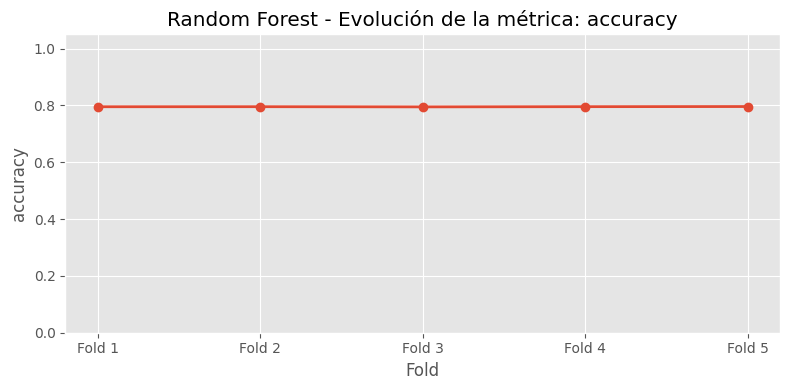

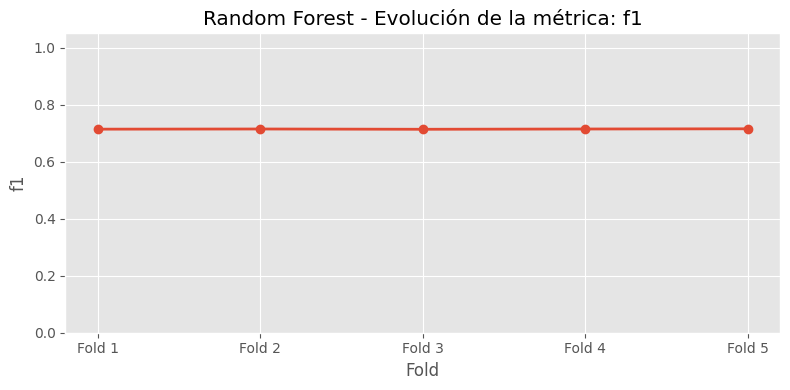

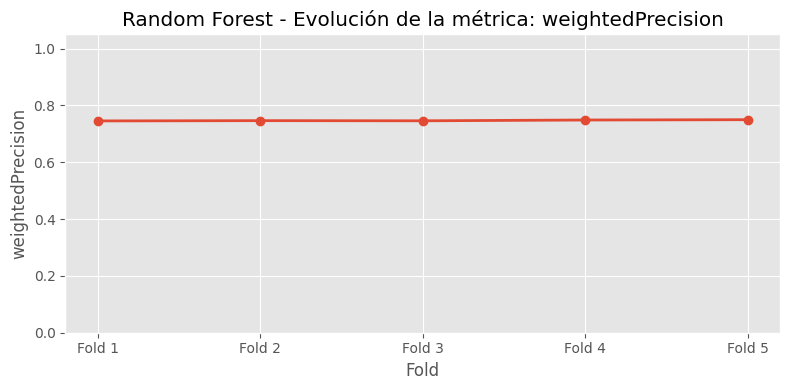

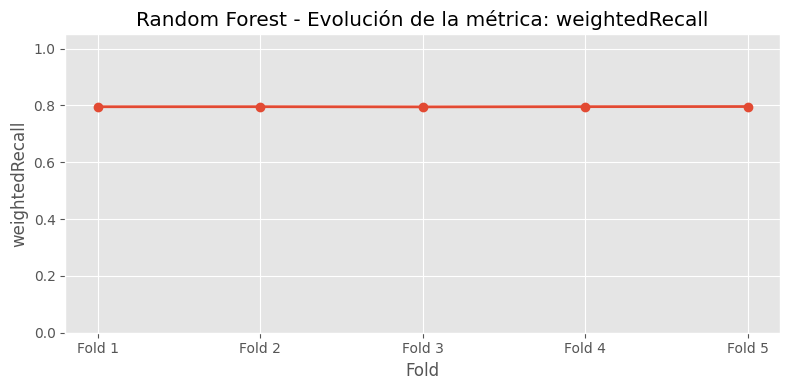

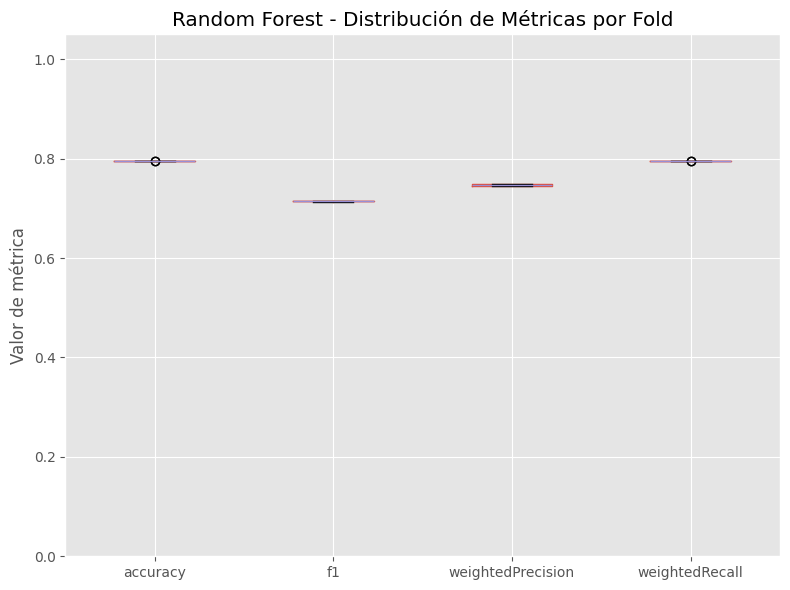

📋 Resumen estadístico - Random Forest


,Media,Desviación estándar
accuracy,0.795359,0.000431
f1,0.714309,0.000631
weightedPrecision,0.747091,0.001880
weightedRecall,0.795359,0.000431
auc,0.588780,0.001450


In [75]:
# Para Random Forest
rf_viz = MetricsVisualizer(rf_metrics, model_name="Random Forest")
rf_viz.show_table()
rf_viz.plot_metrics()
rf_viz.plot_boxplot()
rf_viz.show_summary()


In [ ]:
# Para Gradient Boosted Trees
gbt_viz = MetricsVisualizer(gbt_metrics, model_name="GBT")
gbt_viz.show_table()
gbt_viz.plot_metrics()
gbt_viz.plot_boxplot()
gbt_viz.show_summary()

## 2. (SKIP) Construcción del conjunto de entrenamiento y prueba

En este apartado se toma cada partición Mi generada en el paso anterior y se divide en dos subconjuntos: Entrenamiento (Train) y Prueba (Test).

Antes de separar los datos, se analiza el tamaño de la clase minoritaria en todas las particiones para determinar el porcentaje adecuado de división.
Dependiendo del tamaño de la clase minoritaria, se elige un split (train-test):
* 70%-30% -> si tiene mayor o igual a 100 ejemplos
* 75%-25% -> si tiene entre 60 y 99 ejemplos
* 80%-20% -> si tiene menos de 60 ejemplos

Se decidió realizar de estar manera para asegurar que los grupos más pequeños tengan al menos 20 ejemplos por clase en el conjunto de prueba.

In [20]:
# Analizar las particiones para identificar la clase minoritaria
min_class_size = float('inf')
target_col = "sentiment"

for partition_key, partition_df in partitions_Mi.items():
    class_counts = partition_df.groupBy(target_col).count().collect()
    for row in class_counts:
        if row['count'] < min_class_size:
            min_class_size = row['count']

In [21]:
# Determinar el ratio óptimo basado en la clase minoritaria
if min_class_size >= 100:
    test_ratio = 0.3  # 70-30
elif min_class_size >= 60:
    test_ratio = 0.25  # 75-25
else:
    test_ratio = 0.2  # 80-20

train_ratio = 1.0 - test_ratio

print(f"Ratio óptimo calculado: {train_ratio:.0%} train / {test_ratio:.0%} test")

Ratio óptimo calculado: 70% train / 30% test


#### Separación de datos

La separación se hace a partir de un muestreo estratificado para mantener la misma proporción de clases (`sentiment`) tanto en entrenamiento como en prueba, evitando sesgos.

Primero se toma el conjunto de entrenamiento usando `sampleBy`, y luego se obtiene el conjunto de prueba tomando los registros restantes con `left_anti`. Con esto se busca evitar coincidencias entre ambos conjuntos, garantizando que los datos de prueba sean completamente independientes.

Cabe destacar que, para cada partición, se realiza un guardado incremental en disco, lo que permite reanudar el proceso en caso de interrupciones sin recalcular todo. También, para reducir el tiempo de procesamiento, se optó por implementar procesamiento paralelo y persistencia en memoria.

Fuentes consultadas:

https://www.geeksforgeeks.org/pyspark-sampleby-using-multiple-columns/

https://iomete.com/resources/reference/pyspark/pyspark-join

https://medium.com/@shuklaprashant9264/pyspark-persist-2aa92478081d

https://medium.com/@anupchakole/understanding-threadpoolexecutor-2eed095d21aa

In [3]:
# Guardar los resultados de la partición
output_dir = "outputs/stratified_split"
os.makedirs(output_dir, exist_ok=True)

log_path = os.path.join(output_dir, "split_summary.csv")

# Inicializar log si no existe
if not os.path.exists(log_path):
    with open(log_path, "w") as log_file:
        log_file.write("partition,train_size,test_size,total_size\n")

def process_partition(partition_key, partition_df):
    train_path = f"{output_dir}/train_{partition_key}"
    test_path = f"{output_dir}/test_{partition_key}"

    if os.path.exists(train_path) and os.path.exists(test_path):
        print(f"Saltando partición {partition_key} (ya existe)")
        return

    print(f"Procesando partición {partition_key}...")

    # Persistir para evitar recálculo
    partition_df = partition_df.persist()

    class_counts = partition_df.groupBy(target_col).count().collect()
    fractions = {row[target_col]: train_ratio for row in class_counts}

    train_df = partition_df.sampleBy(target_col, fractions, seed=42).persist()
    test_df = partition_df.join(train_df, on=partition_df.columns, how='left_anti').persist()

    # Guardar en local
    train_df.write.mode("overwrite").parquet(train_path)
    test_df.write.mode("overwrite").parquet(test_path)

    # Calcular tamaños solo una vez (ya persistidos)
    train_size = train_df.count()
    test_size = test_df.count()
    total_size = train_size + test_size

    print(f"Train: {train_size} registros ({train_size/total_size:.1%})")
    print(f"Test: {test_size} registros ({test_size/total_size:.1%})")

    # Registrar en log CSV
    with open(log_path, "a") as log_file:
        log_file.write(f"{partition_key},{train_size},{test_size},{total_size}\n")

    # Liberar memoria
    partition_df.unpersist()
    train_df.unpersist()
    test_df.unpersist()

# ⚙ Configura cuántas particiones en paralelo
max_workers = 4

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for key, df in partitions_Mi.items():
        futures.append(executor.submit(process_partition, key, df))

    # Esperar a que todas terminen
    for future in futures:
        future.result()


NameError: name 'partitions_Mi' is not defined

In [7]:
# Cargar los conjuntos de entrenamiento y prueba guardados
output_dir = "outputs/stratified_split"
train_sets = {}
test_sets = {}

# Buscar todos los archivos parquet guardados
for filename in os.listdir(output_dir):
    if filename.startswith("train_"):
        partition_key = filename[len("train_"):]  # solo quitamos el prefijo
        
        train_path = f"{output_dir}/{filename}"
        test_path = f"{output_dir}/test_{partition_key}"

        try:
            train_df = spark.read.parquet(train_path)
            test_df = spark.read.parquet(test_path)
            
            train_sets[partition_key] = train_df
            test_sets[partition_key] = test_df

            print(f"Partición {partition_key}: "
                  f"{train_df.count()} train, {test_df.count()} test")
        except Exception as e:
            print(f"Error al cargar partición {partition_key}: {e}")


Partición R2_VPN_VY: 133 train, 80 test
Partición R3_VPN_VN: 5445 train, 2393 test
Partición R5_VPY_VN: 309248 train, 132825 test
Partición R1_VPN_VN: 12896 train, 5420 test
Partición R5_VPN_VN: 34505 train, 14686 test
Partición R1_VPY_VN: 50774 train, 21670 test
Partición R4_VPN_VY: 1187 train, 487 test
Partición R3_VPY_VN: 37301 train, 15984 test
Partición R2_VPN_VN: 5043 train, 2165 test
Partición R3_VPN_VY: 439 train, 167 test
Partición R4_VPY_VN: 86077 train, 36696 test
Partición R5_VPN_VY: 1367 train, 569 test
Partición R4_VPN_VN: 11422 train, 4749 test
Partición R2_VPY_VN: 25322 train, 10767 test


In [8]:
log_df = pd.read_csv("outputs/stratified_split/split_summary.csv")
total_train = log_df["train_size"].sum()
total_test = log_df["test_size"].sum()
total_original = log_df["total_size"].sum()

print(f"\n=== RESUMEN FINAL DE DIVISIÓN ===")
print(f"Tamaño total de entrenamiento: {total_train:,} registros")
print(f"Tamaño total de prueba: {total_test:,} registros")
print(f"Suma total de registros: {total_train + total_test:,} registros")
print(f"Tamaño total original: {total_original:,} registros")
print(f"Fracción de entrenamiento: {total_train / total_original:.1%}")
print(f"Fracción de prueba: {total_test / total_original:.1%}")


=== RESUMEN FINAL DE DIVISIÓN ===
Tamaño total de entrenamiento: 581,159 registros
Tamaño total de prueba: 248,658 registros
Suma total de registros: 829,817 registros
Tamaño total original: 829,817 registros
Fracción de entrenamiento: 70.0%
Fracción de prueba: 30.0%


**Observaciones**

Se puede apreciar que la suma de los tamaños de los conjuntos de train y test coinciden con el tamaño original de cada partición Mi. Lo anterior, permite descartar la posibilidad de valores faltantes o duplicados.

## 3. (SKIP) Selección de métricas para medir calidad de resultados

En este apartado se definen y justifican las métricas que se utilizarán para evaluar la calidad de los modelos construidos. Elegir las métricas adecuadas es fundamental porque nos permite entender no solo qué tan bien se ajusta el modelo a los datos, sino que también cómo se comporta frente a nuevos casos, qué tipo de errores comete y cómo balancea entre distintas prioridades (como precisión vs. sensibilidad).

#### Contexto: Amazon Reviews
El conjunto de datos contiene reseñas de productos publicadas en Amazon, centradas en la categoría electrónica. Cada registro incluye variables relevantes como la calificación (`star_rating`), si la compra fue verificada (`verified_purchase`), si participó en el programa Vine (`vine`) y una etiqueta derivada de sentimiento (`sentiment`). El objetivo es construir modelos que puedan clasificar correctamente el sentimiento de las reseñas. 

Dado que se trata de un problema de clasificación binaria, y considerando el tamaño y naturaleza del dataset (grandes volúmenes y con clases desbalanceadas), es necesario usar métricas robustas y que reflejen distintos aspectos del rendimiento del modelo.

#### Selección de métricas

Con base en el entendimiento del problema, se consideró el uso de las siguientes métricas:

**Accuracy:** Mide el porcentaje total de predicciones correctas (ya sean positivas o negativas). En nuestro caso, nos da una visión general de cuántas reseñas de sentimiento fueron clasificadas correctamente. Sin embargo, dada la naturaleza del desbalanceo de clases, no podemos depender solo de esta métrica, porque un modelo que siempre prediga “positivo” podría tener alta precisión, pero no ser útil para detectar las negativas.

**Precision:** De todas las reseñas que el modelo predijo como positivas, indica cuántas realmente lo son. Esto es relevante porque, si queremos usar el modelo para destacar reseñas confiables o promocionar productos con buena reputación, es importante evitar falsos positivos, ya que no queremos etiquetar como positiva una reseña que en realidad es negativa. Lo anterior podría distorcionar el análisis comercial.

**Recall:** De todas las reseñas que realmente son positivas, mide cuántas logró capturar el modelo. Esto es fundamental si queremos capturar la mayor cantidad posible de reseñas positivas para recomendaciones.

**F1-score:** Combina precision y recall, balanceando ambos aspectos. En este caso, es clave porque trabajamos con clases desbalanceadas (hay muchas más reseñas positivas que negativas), y necesitamos una métrica que penalice modelos que solo optimizan una dimensión (por ejemplo, mucha precisión pero poco recall).

**AUC-ROC (Área bajo la curva ROC):** Evalúa la capacidad del modelo para distinguir correctamente entre reseñas positivas y negativas, considerando todos los umbrales posibles. Esto es útil para tener una visión completa del poder discriminativo del modelo, más allá de una decisión binaria fija.


## (SKIP) 4. Entrenamiento de Modelos de Aprendizaje

### Preprocesamiento de los datos

>Nota: Se reutilizaron elementos de la Actividad 3 | Aprendizaje supervisado y no supervisado para llevar a cabo el procesamiento de los datos.

In [11]:
class Preprocessor:
    def __init__(self, columns_for_modeling):
        self.columns = columns_for_modeling
        self.indexed_columns = []

    def merge_partitions(self, partition_dict: dict) -> DataFrame:
        return reduce(lambda df1, df2: df1.unionByName(df2), partition_dict.values())

    def drop_nulls(self, df: DataFrame) -> DataFrame:
        initial_count = df.count()
        print(f"Total de registros antes de eliminar nulos: {initial_count}")

        # Calcular cuántos nulos hay por columna relevante
        for col_name in self.columns:
            null_count = df.filter(F.col(col_name).isNull()).count()
            if null_count > 0:
                print(f"  Columna '{col_name}' tiene {null_count} valores nulos")
        
        # Eliminar filas con nulos en columnas clave
        df_clean = df.dropna(subset=self.columns)
        final_count = df_clean.count()

        print(f"Total de registros después de eliminar nulos: {final_count}")
        print(f"Se eliminaron {initial_count - final_count} registros ({(initial_count - final_count) / initial_count:.2%})\n")
        
        return df_clean

    # def cast_types(self, df: DataFrame) -> DataFrame:
    #     numeric_cols = ["star_rating", "helpful_votes", "total_votes", "sentiment"]
    #     for col_name in numeric_cols:
    #         df = df.withColumn(col_name, col(col_name).cast(IntegerType()))
    #     return df

    def remove_outliers(self, df: DataFrame, columns: list, quantile_error=0.01) -> DataFrame:
        initial_count = df.count()
        print(f"Total inicial: {initial_count} registros")

        for col_name in columns:
            Q1, Q3 = df.approxQuantile(col_name, [0.25, 0.75], quantile_error)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            if IQR == 0:
                print(f"Advertencia: IQR=0 para '{col_name}', se omite filtro de atípicos.")
                continue

            before_count = df.count()
            df = df.filter((F.col(col_name) >= lower_bound) & (F.col(col_name) <= upper_bound))
            after_count = df.count()
            removed = before_count - after_count

            print(f"'{col_name}': límites [{lower_bound:.2f}, {upper_bound:.2f}], eliminados {removed} registros ({removed / before_count:.2%})")
        
        final_count = df.count()
        print(f"Total final después de eliminar atípicos: {final_count} registros")
        print(f"Total eliminado: {initial_count - final_count} registros ({(initial_count - final_count) / initial_count:.2%})\n")
        
        return df
   

    def encode_categoricals(self, df: DataFrame) -> DataFrame:
        categorical_cols = ["vine", "verified_purchase"]
        for col_name in categorical_cols:
            index_col = f"{col_name}_index"
            self.indexed_columns.append(index_col)
            indexer = StringIndexer(inputCol=col_name, outputCol=index_col)
            df = indexer.fit(df).transform(df)
        return df

In [12]:
RELEVANT_COLUMNS_FOR_MODELING = [
    "star_rating", "helpful_votes", "total_votes",
    "vine", "verified_purchase", "sentiment"
]

#### Unión de particiones para construir M

En esta primera etapa, se lleva a cabo la unión de múltiples subconjuntos muestreados de la base original, generados a partir de combinaciones de las variables de caracterización (`star_rating`, `verified_purchase`, `vine`). Esto será de ayuda para contruir un conjunto representativo (M) que conserve la diversidad presente en la base original, evitando sesgos asociados a una partición única.

In [13]:
# Crear instancia del Preprocessor
preprocessor = Preprocessor(columns_for_modeling=RELEVANT_COLUMNS_FOR_MODELING)

# Combinar todas las particiones de entrenamiento (Tri) en un solo DataFrame
df_train = preprocessor.merge_partitions(train_sets)

# Combinar todas las particiones de prueba (Tsi) en un solo DataFrame
df_test = preprocessor.merge_partitions(test_sets)


#### Limpieza de valores nulos

Para poder entrenar los modelos, es importante realizar una limpieza de valores faltantes para evitar errores en el prepocesamiento y mejorar la calidad de estos.

In [14]:
print("=== TRAIN SET ===")
df_train = preprocessor.drop_nulls(df_train)

=== TRAIN SET ===
Total de registros antes de eliminar nulos: 581159
Total de registros después de eliminar nulos: 581159
Se eliminaron 0 registros (0.00%)



In [15]:
print("=== TEST SET ===")
df_test = preprocessor.drop_nulls(df_test)

=== TEST SET ===
Total de registros antes de eliminar nulos: 248658
Total de registros después de eliminar nulos: 248658
Se eliminaron 0 registros (0.00%)



#### Conversión de tipos

En este paso, nos aseguraremos que las variables posean los tipos de datos correctos para que puedan ser procesados correctamente por los algoritmos de ML.

Al utilizar `printSchema()`, se puede apreciar que las variables numéricas (`star_rating`, `helpful_votes`, `total_votes` y `sentiment`) y categóricas (`verified_purchase` y `vine`) están correctamente tipadas.

Esta validación es importante, para evitar errores durante el entrenamiento del modelo.

In [16]:
print("=== TRAIN SET ===")
df_train.printSchema()
# df_train = preprocessor.cast_types(df_train)

=== TRAIN SET ===
root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- sentiment: integer (nullable = true)



In [17]:
print("=== TEST SET ===")
df_test.printSchema()
# df_test = preprocessor.cast_types(df_test)

=== TEST SET ===
root
 |-- marketplace: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- sentiment: integer (nullable = true)



#### Detección y tratamiento de valores atípicos

Para evitar que los valores extremos puedan distorsionar las distribuciones e impactar sobre la capacidad de generalización de los modelos, se aplicó una técnica de detección y eliminación de valores atípicos (outliers) sobre las columnas `total_votes` y `helpful_votes`, utilizando el método del rango intercuartílico (IQR). Se decidió utilizar IQR, ya que es una técnica robusta que identifica outliers con base en la dispersión natural de los datos, en lugar de utilizar un umbral o threshold manual.

In [18]:
print("=== TRAIN SET ===")
df_train = preprocessor.remove_outliers(df_train, columns=["helpful_votes", "total_votes"], quantile_error=0.01)

=== TRAIN SET ===
Total inicial: 581159 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 51992 registros (8.95%)
'total_votes': límites [-1.50, 2.50], eliminados 22181 registros (4.19%)
Total final después de eliminar atípicos: 506986 registros
Total eliminado: 74173 registros (12.76%)



In [19]:
print("=== TEST SET ===")
df_test = preprocessor.remove_outliers(df_test, columns=["helpful_votes", "total_votes"], quantile_error=0.01)

=== TEST SET ===
Total inicial: 248658 registros
'helpful_votes': límites [-1.50, 2.50], eliminados 22084 registros (8.88%)
'total_votes': límites [-1.50, 2.50], eliminados 9444 registros (4.17%)
Total final después de eliminar atípicos: 217130 registros
Total eliminado: 31528 registros (12.68%)



#### Transformación de variables categóricas

Como se revisó anteriormente, se cuenta con variables categóricas (`verified_purchase` y `vine`), por lo que es relevante llevar a cabo una codificación para el entrenamiento de los modelos. Se decidió utilizar `StringIndexer` que es una técnica de codificación por frecuencia de aparación que no incrementa el número de columnas y funciona bien para categorías binarias. En este caso, ambas columnas poseen valores de 'Y' y 'N'.

In [20]:
df_train = preprocessor.encode_categoricals(df_train)
df_train.select("vine_index", "verified_purchase_index").distinct().show(truncate=False)

+----------+-----------------------+
|vine_index|verified_purchase_index|
+----------+-----------------------+
|1.0       |1.0                    |
|0.0       |1.0                    |
|0.0       |0.0                    |
+----------+-----------------------+



In [21]:
df_test = preprocessor.encode_categoricals(df_test)
df_test.select("vine_index", "verified_purchase_index").distinct().show(truncate=False)

+----------+-----------------------+
|vine_index|verified_purchase_index|
+----------+-----------------------+
|1.0       |1.0                    |
|0.0       |1.0                    |
|0.0       |0.0                    |
+----------+-----------------------+



#### Feature Engineering

Adicionalmenrte, se decidió crear nuevas variables para experimentar sobre el desempeño del modelo. Se espera que con las siguientes columnas, el modelo sea capaz de capturar mejor los patrones y relaciones:
- `vote_ratio`: Representa la proporción de votos útiles entre todos los votos recibidos en una reseña.
- `log_total_votes` y `log_total_votes`: Al aplicar transformación logarítmica, se reduce el impacto de los valores extremos y permite que el modelo aprenda mejor sobre una escala homogénea.

In [22]:
df_train = df_train \
    .withColumn("vote_ratio", col("helpful_votes") / (col("total_votes") + 1)) \
    .withColumn("log_total_votes", log1p(col("total_votes"))) \
    .withColumn("log_helpful_votes", log1p(col("helpful_votes")))

In [23]:
df_test = df_test \
    .withColumn("vote_ratio", col("helpful_votes") / (col("total_votes") + 1)) \
    .withColumn("log_total_votes", log1p(col("total_votes"))) \
    .withColumn("log_helpful_votes", log1p(col("helpful_votes")))

#### Selección y entrenamiento de modelos

En esta sección se entrenan dos modelos supervisados para predecir el sentimiento de las reseñas: **Random Forest** y **Gradient Boosted Trees (GBT)**. 

**Random Forest**
* Se usó `VectorAssembler` para combinar las variables seleccionadas (`log_helpful_votes`, `log_total_votes`, `vote_ratio`, `vine_index`, `verified_purchase_index`) en un único vector de entrada, seguido por un `RandomForestClassifier`.
* Se empleó un `CrossValidator` para explorar combinaciones de número de árboles (`numTrees`: 20, 50) y profundidad máxima (`maxDepth`: 5, 10), usando 3 pliegues de validación cruzada.

**GBT**
* Al igual que en el Random Forest, se utilizó un pipeline con `VectorAssembler` seguido por un `GBTClassifier`.
* Se exploraron combinaciones de número máximo de iteraciones (`maxIter`: 20, 50), profundidad máxima (`maxDepth`: 3, 5) y tamaño del paso (`stepSize`: 0.05, 0.1), usando validación cruzada.

Los modelos son evaluados usando las métricas seleccionadas (accuracy, precision, recall, F1, AUC-ROC) en la sección **3. Selección de métricas para medir calidad de resultados**.


In [38]:
def run_random_forest_cv(df_train, df_test, feature_cols, seed=42):
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    rf = RandomForestClassifier(featuresCol="features", labelCol="sentiment", seed=seed)
    # rf = RandomForestClassifier(featuresCol="features", labelCol="sentiment", seed=seed, weightCol="class_weight")

    pipeline = Pipeline(stages=[assembler, rf])

    param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [20, 50]) \
        .addGrid(rf.maxDepth, [5, 10]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")

    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, seed=seed)

    cv_model = cv.fit(df_train)
    predictions = cv_model.transform(df_test)

    accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
    f1 = evaluator.setMetricName("f1").evaluate(predictions)
    precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

    print(f"Random Forest (CV) Accuracy: {accuracy:.4f}")
    print(f"Random Forest (CV) F1 Score: {f1:.4f}")
    print(f"Random Forest (CV) Precision: {precision:.4f}")
    print(f"Random Forest (CV) Recall: {recall:.4f}")

    if df_train.select('sentiment').distinct().count() == 2:
        binary_evaluator = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction")
        auc = binary_evaluator.evaluate(predictions)
        print(f"Random Forest (CV) AUC-ROC: {auc:.4f}")
    
    return cv_model, predictions


In [39]:
feature_cols = [
    "log_helpful_votes", 
    "log_total_votes", 
    "vote_ratio", 
    "vine_index", 
    "verified_purchase_index"
]

In [40]:
# Ejecutar el modelo Random Forest con validación cruzada
rf_model, rf_predictions = run_random_forest_cv(
    df_train,
    df_test,
    feature_cols=feature_cols
)

Random Forest (CV) Accuracy: 0.7959
Random Forest (CV) F1 Score: 0.7152
Random Forest (CV) Precision: 0.7483
Random Forest (CV) Recall: 0.7959
Random Forest (CV) AUC-ROC: 0.5810


In [41]:
def run_gbt_cv(df_train, df_test, feature_cols, seed=42):
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    gbt = GBTClassifier(featuresCol="features", labelCol="sentiment", seed=seed)

    pipeline = Pipeline(stages=[assembler, gbt])

    param_grid = ParamGridBuilder() \
        .addGrid(gbt.maxIter, [20, 50]) \
        .addGrid(gbt.maxDepth, [3, 5]) \
        .addGrid(gbt.stepSize, [0.05, 0.1]) \
        .build()

    evaluator = MulticlassClassificationEvaluator(labelCol="sentiment", predictionCol="prediction", metricName="f1")

    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, seed=seed)

    cv_model = cv.fit(df_train)
    predictions = cv_model.transform(df_test)

    accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
    f1 = evaluator.setMetricName("f1").evaluate(predictions)
    precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)

    print(f"GBT (CV) Accuracy: {accuracy:.4f}")
    print(f"GBT (CV) F1 Score: {f1:.4f}")
    print(f"GBT (CV) Precision: {precision:.4f}")
    print(f"GBT (CV) Recall: {recall:.4f}")

    if df_train.select('sentiment').distinct().count() == 2:
        binary_evaluator = BinaryClassificationEvaluator(labelCol="sentiment", rawPredictionCol="rawPrediction")
        auc = binary_evaluator.evaluate(predictions)
        print(f"GBT (CV) AUC-ROC: {auc:.4f}")
    
    return cv_model, predictions

In [42]:
# Ejecutar el modelo GBT con validación cruzada
gbt_model, gbt_predictions = run_gbt_cv(
    df_train,
    df_test,
    feature_cols=feature_cols
)

GBT (CV) Accuracy: 0.7959
GBT (CV) F1 Score: 0.7152
GBT (CV) Precision: 0.7483
GBT (CV) Recall: 0.7959
GBT (CV) AUC-ROC: 0.5926


## (SKIP) 5. Análisis de resultados

| **Métrica** | **Random Forest** | **GBT** |
| ----------- | ----------------- | ------- |
| Accuracy    | 0.7959            | 0.7959  |
| F1 Score    | 0.7152            | 0.7152  |
| Precision   | 0.7483            | 0.7483  |
| Recall      | 0.7959            | 0.7959  |
| AUC-ROC     | 0.5810            | 0.5926  |

Después de entrenar los modelos Random Forest y Gradient Boosted Trees, ambos mostraron resultados muy similares, como se ve en la tabla anterior. Esto podría deberse a que el conjunto de datos presenta, posiblemente, patrones bastante claros, lo que facilita la tarea de clasificación. Ambos modelos lograron predecir correctamente cerca del 80% de las reseñas, con un equilibrio aceptable entre precisión y recall. No obstante, las métricas AUC-ROC (entre 0.58 y 0.59) fueron relativamente bajas, lo que sugiere que, si bien los modelos aciertan bien en una clase, tienen dificultades para diferenciar entre las clases.

Como se exploró en la actividad 3, se ha identificado que existe un desbalance entre clases, con una fuerte predominancia de la clase positiva. Este desbalance puede limitar el desempeño de los modelos, particularmente en métricas sensibles como el AUC-ROC, y puede llevar a que los algoritmos favorezcan la clase mayoritaria para maximizar accuracy, dejando de lado una buena discriminación.

**Reflexión Final**

Personalmente, considero que esta actividad me ayudó a reconocer la importancia de trabajar con datos representativos y el proceso que implica llegar a una muestra que sea útil para analizar y entrenar nuestros modelos. También es relevante recordar que evaluar modelos de ML no se trata solo de elegir una métrica al azar, sino de entender qué mide cada una y cómo se alinea con los objetivos del problema o fenómeno estudiado. Métricas como el F1-score y el AUC-ROC ofrecen una perspectiva más completa sobre la capacidad del modelo para generalizar y discriminar entre clases. Finalmente, me gustaría destacar que el procesamiento paralelo, la persistencia en memoria y el guardado incremental son estrategias fundamentales para trabajar de forma eficiente y robusta con grandes volúmenes de datos.